导包

In [ ]:

import bisect
from datetime import datetime

import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # SimHei缺少一些数学符号

读数据

In [ ]:
filepath = 'data/1.4.csv'
df = pd.read_csv(filepath, sep=',')

print(df.head())


              datetime  discharge  silt content
0  2004-06-29 08:00:00       1800            32
1  2004-06-29 20:00:00       1900            60
2  2004-06-30 08:00:00       2100            75
3  2004-06-30 20:00:00       2200            85
4  2004-07-01 08:00:00       2300            90


数据预处理

In [20]:
# 基准时间点（为df的datatime中的第一个）
base_dt = datetime.strptime(df['datetime'][0], '%Y-%m-%d %H:%M:%S')
# 计算每个数据点相对于基准时间（第一个数据点）的小时数 # 累计
df['hours'] = df['datetime'].apply(lambda x: (datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - base_dt).total_seconds() / 3600)
df['minutes'] = df['hours'] * 60
df['seconds'] = df['hours'] * 3600
# 计算每个数据点的排沙量（水流量 × 含沙量）
df['discharge_silt'] = df['discharge'] * df['silt content']
print(df.head())

              datetime  discharge  silt content  hours  minutes   seconds  \
0  2004-06-29 08:00:00       1800            32    0.0      0.0       0.0   
1  2004-06-29 20:00:00       1900            60   12.0    720.0   43200.0   
2  2004-06-30 08:00:00       2100            75   24.0   1440.0   86400.0   
3  2004-06-30 20:00:00       2200            85   36.0   2160.0  129600.0   
4  2004-07-01 08:00:00       2300            90   48.0   2880.0  172800.0   

   discharge_silt  
0           57600  
1          114000  
2          157500  
3          187000  
4          207000  


### 1.4(1) 

用插值函数

求出给定时间的含沙量与总含沙量

In [ ]:
def get_sediment_discharge(input_dt, kind='cubic', time_accuracy='hour'):
    """
    input_dt: 输入的时间点
    kind: 插值方法 (''linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic'')
    time_accuracy: 时间精度 ('hour', 'minute', 'second')
    """
     # 取值处理
    if type(input_dt) == str:
        input_dt = datetime.strptime(input_dt, '%Y-%m-%d %H:%M:%S')
    if kind not in ['linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic']:
        print(f'\033[1;33m[Warning]\033[0m: kind参数只能取值"linear", "nearest", "zero", "slinear", "quadratic", "cubic"。您使用的是"{kind}"，将默认使用"cubic"')
        kind = 'cubic'
    if time_accuracy not in ['hour', 'minute', 'second']:
        print(f'\033[1;33m[Warning]\033[0m: time_accuracy参数只能取值"hour", "minute", "second"。您使用的是"{time_accuracy}"，将默认使用"hour"')
        time_accuracy = 'hour'
        
    delta = input_dt - base_dt
    seconds = delta.total_seconds()
    # 越界处理
    if seconds <= df['seconds'].values[0]:
        return df['discharge_silt'].values[0]
    if seconds >= df['seconds'].values[-1]:
        return df['discharge_silt'].values[-1]
    
    if time_accuracy == 'hour':
        hours = seconds / 3600
        # 创建插值函数
        d_interpolate = interpolate.interp1d(df['hours'], df['discharge'], kind=kind)
        sc_interpolate = interpolate.interp1d(df['hours'], df['silt content'], kind=kind)
        return d_interpolate(hours) * sc_interpolate(hours)
        
    elif time_accuracy == 'minute':
        minutes = seconds / 60
        # 创建插值函数
        d_interpolate = interpolate.interp1d(df['minutes'], df['discharge'], kind=kind)
        sc_interpolate = interpolate.interp1d(df['minutes'], df['silt content'], kind=kind)
        return d_interpolate(minutes) * sc_interpolate(minutes)
        
    elif time_accuracy == 'second':
        # 创建插值函数
        d_interpolate = interpolate.interp1d(df['seconds'], df['discharge'], kind=kind)
        sc_interpolate = interpolate.interp1d(df['seconds'], df['silt content'], kind=kind)
        return d_interpolate(seconds) * sc_interpolate(seconds)
        
    
# 使用方法

# output = get_sediment_discharge(datetime.strptime('2004-07-05 10:30:00', '%Y-%m-%d %H:%M:%S'), kind='cubic', time_accuracy='hour')
output  = get_sediment_discharge('2004-07-05 10:30:00')
print(output)
    

306721.8477143847


1.4(1).1 画图

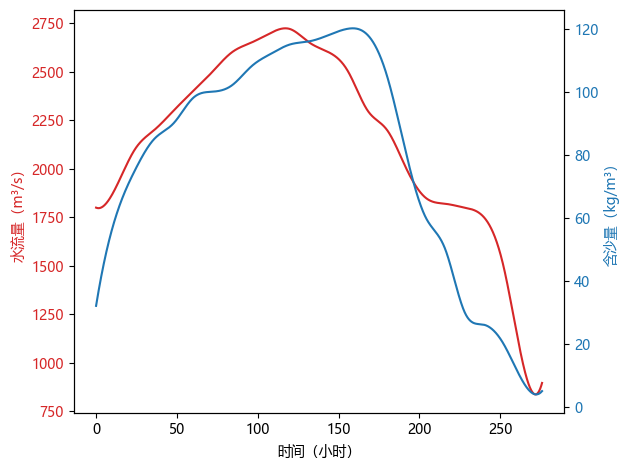

In [21]:
# 画图，每hour插值一次
# 为了效率，不使用上述函数，直接一次插值就搞定

hours = np.arange(0, df['hours'].values[-1], 0.1)
d_interpolate = interpolate.interp1d(df['hours'], df['discharge'], kind='cubic')
sc_interpolate = interpolate.interp1d(df['hours'], df['silt content'], kind='cubic')
discharge = d_interpolate(hours)
silt_content = sc_interpolate(hours)
discharge_silt = discharge * silt_content

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('时间（小时）')
ax1.set_ylabel('水流量（m³/s）', color=color)
ax1.plot(hours, discharge, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('含沙量（kg/m³）', color=color)
ax2.plot(hours, silt_content, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [ ]:
def get_total_sediment(input_dt, kind='cubic', time_accuracy='hour'):
    """
    input_dt: 输入的时间点
    kind: 插值方法 (''linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic'')
    time_accuracy: 时间精度 ('hour', 'minute', 'second')
    """
    # 取值处理
    if type(input_dt) == str:
        input_dt = datetime.strptime(input_dt, '%Y-%m-%d %H:%M:%S')
    if kind not in ['linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic']:
        print(f'\033[1;33m[Warning]\033[0m: kind参数只能取值"linear", "nearest", "zero", "slinear", "quadratic", "cubic"。您使用的是"{kind}"，将默认使用"cubic"')
        kind = 'cubic'
    if time_accuracy not in ['hour', 'minute', 'second']:
        print(f'\033[1;33m[Warning]\033[0m: time_accuracy参数只能取值"hour", "minute", "second"。您使用的是"{time_accuracy}"，将默认使用"hour"')
        time_accuracy = 'hour'
    
    delta = input_dt - base_dt
    seconds = delta.total_seconds()
    
    # 越界处理
    if seconds < df['seconds'].values[0]:
        print(f'\033[1;33m[Warning]\033[0m: \t时间点超出数据范围，最小时间点为{df["datetime"].values[0]}\n\t\t返回0')
        return 0
    if seconds > df['seconds'].values[-1]:
        print(f'\033[1;33m[Warning]\033[0m: \t时间点超出数据范围，最大时间点为{df["datetime"].values[-1]}\n\t\t强制将时间设为{df['datetime'].values[-1]}')
        seconds = df['seconds'].values[-1]

    # 积分计算 总排沙量
    # # 不复用get_sediment_discharge，那样太低效了(除非放在同一个类中，共享插值函数)
    if time_accuracy == 'hour':
        hours = seconds / 3600
        # print(f'\033[1;34m[info]\033[0m: 将执行{hours}次循环')
        # 创建插值函数
        d_interpolate = interpolate.interp1d(df['hours'], df['discharge'], kind=kind)
        sc_interpolate = interpolate.interp1d(df['hours'], df['silt content'], kind=kind)
        # 计算积分
        total_sediment = 0
        for i in range(1, int(hours)+1):
            total_sediment += d_interpolate(i) * sc_interpolate(i)
        total_sediment *= 3600
        return total_sediment
    if time_accuracy == 'minute':
        minutes = seconds / 60
        # print(f'\033[1;34m[info]\033[0m: 将执行{minutes}次循环')
        d_interpolate = interpolate.interp1d(df['minutes'], df['discharge'], kind=kind)
        sc_interpolate = interpolate.interp1d(df['minutes'], df['silt content'], kind=kind)
        total_sediment = 0
        for i in range(1, int(minutes)+1):
            total_sediment += d_interpolate(i) * sc_interpolate(i)
        total_sediment *= 60
        return total_sediment
    if time_accuracy == 'second':
        print(f'\033[1;33m[Warning]\033[0m: \t时间精度为"second"时，数据量太大，建议使用"hour"或"minute"。\n\t\t将执行{seconds}次循环')
        d_interpolate = interpolate.interp1d(df['seconds'], df['discharge'], kind=kind)
        sc_interpolate = interpolate.interp1d(df['seconds'], df['silt content'], kind=kind)
        total_sediment = 0
        for i in range(1, int(seconds)+1):
            total_sediment += d_interpolate(i) * sc_interpolate(i)
        return total_sediment
    
output = get_total_sediment(datetime.strptime('2004-07-05 10:30:00', '%Y-%m-%d %H:%M:%S'), kind='cubic', time_accuracy='second')
print(output)

# 2004-06-29 08:00:00 cubic, second # 0
# 2004-07-05 10:30:00 cubic, second # 124257360468.90126
# 2004-07-10 20:00:00 cubic, second # 184432711751.07434


[Warning]: 	时间精度为"second"时，数据量太大，建议使用"hour"或"minute"。
		将执行527400.0次循环
124257360468.90126


1.4(1).2 画图

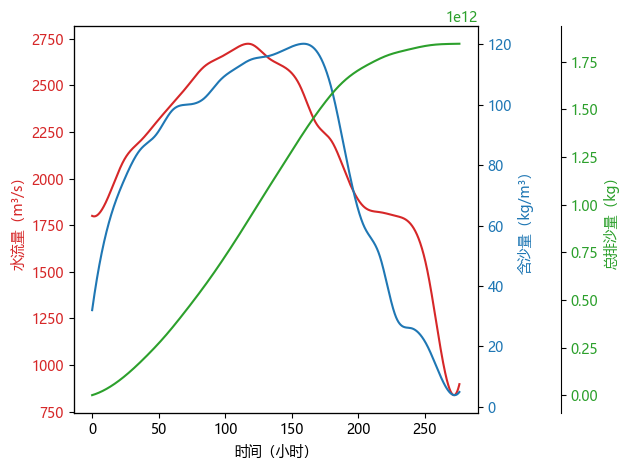

In [22]:
# 画图，总排沙量
hours = np.arange(0, df['hours'].values[-1], 0.1)
d_interpolate = interpolate.interp1d(df['hours'], df['discharge'], kind='cubic')
sc_interpolate = interpolate.interp1d(df['hours'], df['silt content'], kind='cubic')
discharge = d_interpolate(hours)
silt_content = sc_interpolate(hours)
discharge_silt = discharge * silt_content * 3600 # kg/h
total_sediment = [0 for i in range(len(hours))]
for i in range(1, len(hours)):
    total_sediment[i] = total_sediment[i-1] + discharge_silt[i]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('时间（小时）')
ax1.set_ylabel('水流量（m³/s）', color=color)
ax1.plot(hours, discharge, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('含沙量（kg/m³）', color=color)
ax2.plot(hours, silt_content, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('总排沙量（kg）', color=color)
ax3.plot(hours, total_sediment, color=color)
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

### 1.4 (2)

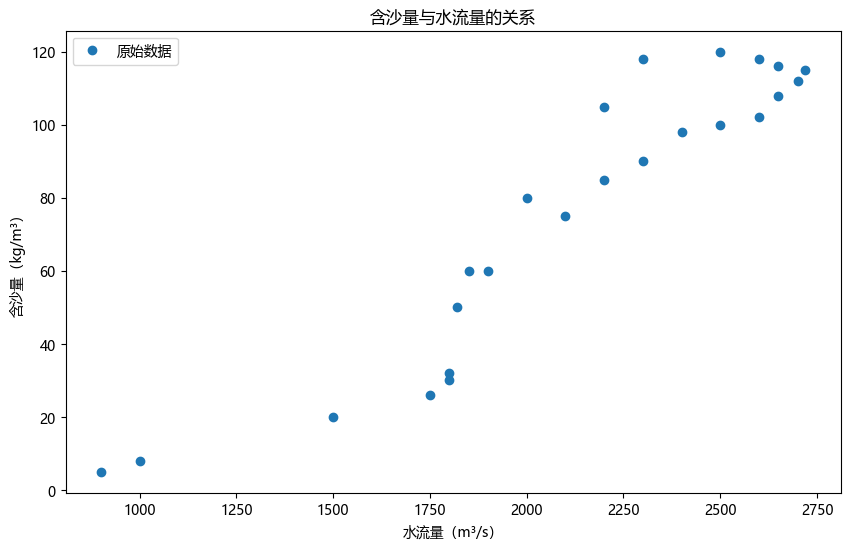

In [23]:
# 画出含沙量与水流量的关系
plt.figure(figsize=(10, 6))
plt.plot(df['discharge'], df['silt content'], 'o', label='原始数据')
plt.xlabel('水流量（m³/s）')
plt.ylabel('含沙量（kg/m³）')
plt.title('含沙量与水流量的关系')
plt.legend()
plt.show()

# test

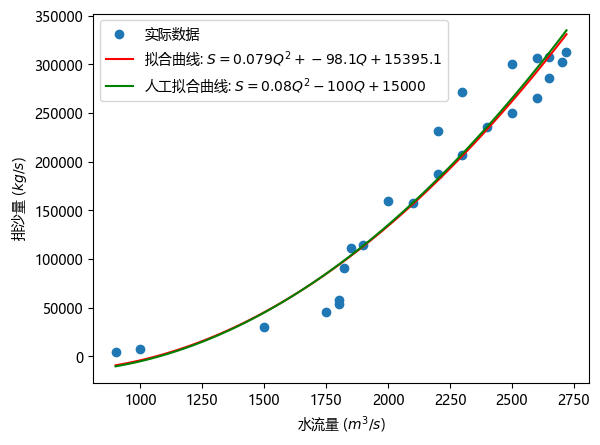

R² = 0.938


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 数据提取（假设已加载为列表）
# Q = [1800, 1900, 2100, 2200, 2300, 2400, 2500, 2600, 2650, 2700, 2720, 2650, 2600, 2500, 2300, 2200, 2000, 1850, 1820, 1800, 1750, 1500, 1000, 900]
# S = [q * c for q, c in zip(Q, [32, 60, 75, 85, 90, 98, 100, 102, 108, 112, 115, 116, 118, 120, 118, 105, 80, 60, 50, 30, 26, 20, 8, 5])]
Q = df['discharge'].values
S = df['discharge_silt'].values

# 多项式拟合（二次）
coefficients = np.polyfit(Q, S, 2)
a, b, c = coefficients
Q_fit = np.linspace(min(Q), max(Q), 100)
S_fit = a * Q_fit**2 + b * Q_fit + c
S_manual = 0.08 * Q_fit**2 - 100 * Q_fit + 15000
# 可视化
plt.scatter(Q, S, label="实际数据")
plt.plot(Q_fit, S_fit, 'r', label=f"拟合曲线: $S = {a:.3f}Q^2 + {b:.1f}Q + {c:.1f}$")
plt.plot(Q_fit, S_manual, 'g', label="人工拟合曲线: $S = 0.08Q^2 - 100Q + 15000$")
plt.xlabel("水流量 ($m^3/s$)")
plt.ylabel("排沙量 ($kg/s$)")
plt.legend()
plt.show()

# 计算R²
r2 = r2_score(S, np.polyval(coefficients, Q))
print(f"R² = {r2:.3f}")

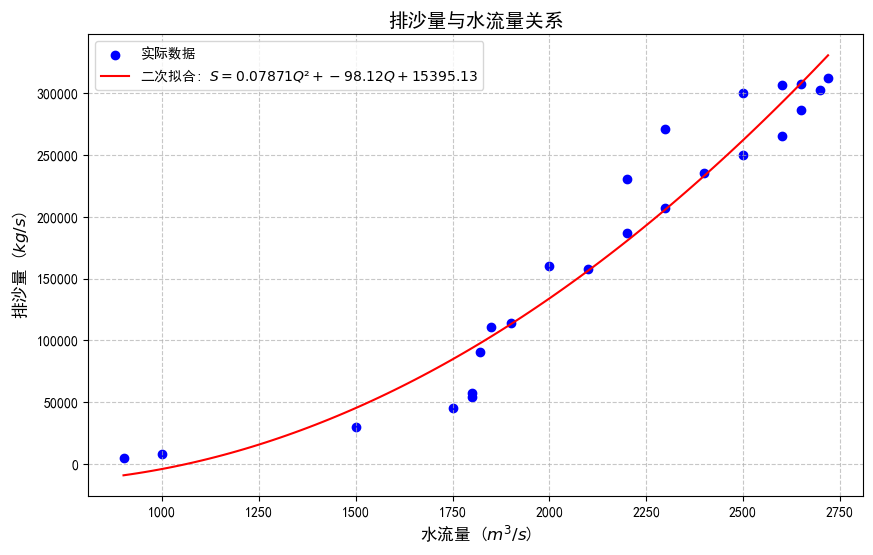

拟合优度 R² = 0.938


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 原始数据
Q = [1800, 1900, 2100, 2200, 2300, 2400, 2500, 2600, 2650, 2700, 2720, 2650, 
     2600, 2500, 2300, 2200, 2000, 1850, 1820, 1800, 1750, 1500, 1000, 900]
C = [32, 60, 75, 85, 90, 98, 100, 102, 108, 112, 115, 116, 
     118, 120, 118, 105, 80, 60, 50, 30, 26, 20, 8, 5]
S = [q * c for q, c in zip(Q, C)]

# 二次多项式拟合
coefficients = np.polyfit(Q, S, 2)
a, b, c = coefficients
Q_fit = np.linspace(min(Q), max(Q), 100)
S_fit = a * Q_fit**2 + b * Q_fit + c

# 可视化
plt.figure(figsize=(10, 6))
plt.scatter(Q, S, color='blue', label='实际数据')
plt.plot(Q_fit, S_fit, color='red', label=f'二次拟合: $S = {a:.5f}Q² + {b:.2f}Q + {c:.2f}$')
plt.xlabel('水流量 ($m^3/s$)', fontsize=12)
plt.ylabel('排沙量 ($kg/s$)', fontsize=12)
plt.title('排沙量与水流量关系', fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# 模型评估
r2 = r2_score(S, np.polyval(coefficients, Q))
print(f'拟合优度 R² = {r2:.3f}')